/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
=

# Install dependencies
!pip install torch torchvision torchaudio
!pip install opencv-python pillow numpy matplotlib
!pip install lpips tensorboard
!pip install basicsr realesrgan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 25.8 MB/s eta 0:00:00
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214818 sha256=dd7b5cfacdf6dd9e5cd89b29f15733c14377d07962657dfe75df73a49efad245
  Stored in directory: /root/.cache/pip/wheels/9a/e3/e4/58f29bfabb622dd40b6d9839318ce5bf092062b81ca3aa19ea
  Created wheel for f

In [2]:
# Clone Real-ESRGAN repository
!git clone https://github.com/xinntao/Real-ESRGAN.git


Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 759, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 759 (delta 106), reused 98 (delta 98), pack-reused 638 (from 1)
Receiving objects: 100% (759/759), 5.38 MiB | 20.94 MiB/s, done.
Resolving deltas: 100% (415/415), done.


In [3]:
%cd Real-ESRGAN


/content/Real-ESRGAN


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!mkdir -p /content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments


In [6]:
!mkdir -p /content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/checkpoints



In [7]:
!mkdir -p /content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/logs


In [8]:
!mkdir -p /content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/results

In [ ]:
# ============================================================================
# DATASET PREPARATION
# ============================================================================

import os
import cv2
import numpy as np
import random
from pathlib import Path
from PIL import Image
import shutil

In [10]:
# Download DIV2K dataset (100 training images subset)
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip


--2025-10-05 15:00:29--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2025-10-05 15:00:30--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  20.0MB/s    in 2m 49s  

2025-10-05 15:03:20 (19.9 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]



In [11]:
!unzip -q DIV2K_train_HR.zip -d /content/datasets

In [12]:
# Select 100 images for training, 20 for validation
def prepare_subset_dataset():
    hr_path = Path('/content/datasets/DIV2K_train_HR')
    train_path = Path('/content/datasets/DIV2K_train_subset')
    val_path = Path('/content/datasets/DIV2K_val_subset')

    train_path.mkdir(parents=True, exist_ok=True)
    val_path.mkdir(parents=True, exist_ok=True)

    all_images = sorted(list(hr_path.glob('*.png')))
    random.seed(42)
    random.shuffle(all_images)

    # First 100 for training, next 20 for validation
    train_images = all_images[:100]
    val_images = all_images[100:120]

    print(f"Copying {len(train_images)} training images...")
    for img in train_images:
        shutil.copy(img, train_path / img.name)

    print(f"Copying {len(val_images)} validation images...")
    for img in val_images:
        shutil.copy(img, val_path / img.name)

    print("Dataset preparation complete!")
    return train_path, val_path

train_path, val_path = prepare_subset_dataset()

Copying 100 training images...
Copying 20 validation images...
Dataset preparation complete!


In [ ]:
# ============================================================================
#  DEGRADATION MODEL
# ============================================================================

import torch
import torch.nn.functional as F
from scipy import signal
from scipy.ndimage import gaussian_filter

class RealESRGANDegradation:
    """Realistic degradation pipeline for training"""

    def __init__(self):
        self.blur_kernel_sizes = [7, 9, 11, 13, 15, 17, 19, 21]
        self.noise_levels = np.arange(0, 26)
        self.jpeg_qualities = np.arange(60, 96)

    def random_blur_kernel(self, size):
        """Generate random blur kernel"""
        kernel_type = random.choice(['isotropic', 'anisotropic'])

        if kernel_type == 'isotropic':
            sigma = np.random.uniform(0.2, 3.0)
            kernel = self._gaussian_kernel_2d(size, sigma)
        else:
            sigma_x = np.random.uniform(0.5, 4.0)
            sigma_y = np.random.uniform(0.5, 4.0)
            theta = np.random.uniform(0, np.pi)
            kernel = self._anisotropic_gaussian_kernel(size, sigma_x, sigma_y, theta)

        return kernel / kernel.sum()

    def _gaussian_kernel_2d(self, size, sigma):
        """2D Gaussian kernel"""
        kernel = cv2.getGaussianKernel(size, sigma)
        kernel = np.outer(kernel, kernel)
        return kernel

    def _anisotropic_gaussian_kernel(self, size, sigma_x, sigma_y, theta):
        """Anisotropic Gaussian kernel"""
        coords = np.arange(size) - size // 2
        x, y = np.meshgrid(coords, coords)

        x_rot = x * np.cos(theta) + y * np.sin(theta)
        y_rot = -x * np.sin(theta) + y * np.cos(theta)

        kernel = np.exp(-(x_rot**2 / (2 * sigma_x**2) + y_rot**2 / (2 * sigma_y**2)))
        return kernel

    def apply_blur(self, img, kernel):
        """Apply blur with given kernel"""
        img = cv2.filter2D(img, -1, kernel)
        return img

    def add_noise(self, img, noise_level):
        """Add Gaussian noise"""
        noise = np.random.normal(0, noise_level, img.shape)
        noisy_img = img + noise
        return np.clip(noisy_img, 0, 255)

    def sinc_filter(self, img):
        """Apply sinc filter (ringing artifacts)"""
        cutoff = np.random.uniform(0.6, 1.2)
        # Simplified sinc filter implementation
        kernel_size = 21
        kernel = self._sinc_kernel(kernel_size, cutoff)
        img = cv2.filter2D(img, -1, kernel)
        return img

    def _sinc_kernel(self, size, cutoff):
        """Generate sinc kernel"""
        x = np.linspace(-size//2, size//2, size)
        kernel_1d = np.sinc(cutoff * x) * cutoff
        kernel_2d = np.outer(kernel_1d, kernel_1d)
        return kernel_2d / kernel_2d.sum()

    def jpeg_compress(self, img, quality):
        """Apply JPEG compression"""
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
        _, encimg = cv2.imencode('.jpg', img, encode_param)
        img = cv2.imdecode(encimg, 1)
        return img

    def degrade(self, hr_img, scale=4):
        """Apply full degradation pipeline"""
        img = hr_img.copy()

        # First degradation
        kernel_size = random.choice(self.blur_kernel_sizes)
        kernel = self.random_blur_kernel(kernel_size)
        img = self.apply_blur(img, kernel)

        # Downsample
        h, w = img.shape[:2]
        img = cv2.resize(img, (w//scale, h//scale), interpolation=cv2.INTER_CUBIC)

        # Add noise
        noise_level = random.choice(self.noise_levels)
        img = self.add_noise(img, noise_level)

        # Sinc filter
        img = self.sinc_filter(img)

        # Second degradation (50% probability)
        if random.random() < 0.5:
            kernel_size = random.choice(self.blur_kernel_sizes)
            kernel = self.random_blur_kernel(kernel_size)
            img = self.apply_blur(img, kernel)

            noise_level = random.choice(self.noise_levels[:16])  # Lower noise
            img = self.add_noise(img, noise_level)

        # JPEG compression
        quality = random.choice(self.jpeg_qualities)
        img = self.jpeg_compress(img, quality)

        return np.clip(img, 0, 255).astype(np.uint8)

In [ ]:
# ============================================================================
# DATASET AND DATALOADER
# ============================================================================

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class DIV2KDataset(Dataset):
    def __init__(self, hr_path, patch_size=128, scale=4, augment=True):
        self.hr_path = Path(hr_path)
        self.hr_images = sorted(list(self.hr_path.glob('*.png')))
        self.patch_size = patch_size
        self.scale = scale
        self.augment = augment
        self.degradation = RealESRGANDegradation()

        print(f"Dataset initialized with {len(self.hr_images)} images")

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        # Load HR image
        hr_img = cv2.imread(str(self.hr_images[idx]))
        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)

        # Random crop
        h, w = hr_img.shape[:2]
        crop_size = self.patch_size * self.scale

        if h > crop_size and w > crop_size:
            top = random.randint(0, h - crop_size)
            left = random.randint(0, w - crop_size)
            hr_img = hr_img[top:top+crop_size, left:left+crop_size]
        else:
            hr_img = cv2.resize(hr_img, (crop_size, crop_size))

        # Augmentation
        if self.augment:
            # Random horizontal flip
            if random.random() < 0.5:
                hr_img = np.fliplr(hr_img).copy()  # FIX: .copy() creates contiguous array

            # Random rotation
            k = random.randint(0, 3)
            if k > 0:  # Only rotate if k > 0
                hr_img = np.rot90(hr_img, k).copy()  # FIX: .copy() creates contiguous array

        # Generate LR image through degradation
        lr_img = self.degradation.degrade(hr_img, self.scale)

        # Convert to tensor - ensure contiguous memory
        hr_tensor = torch.from_numpy(np.ascontiguousarray(hr_img.transpose(2, 0, 1))).float() / 255.0
        lr_tensor = torch.from_numpy(np.ascontiguousarray(lr_img.transpose(2, 0, 1))).float() / 255.0

        return {'lr': lr_tensor, 'hr': hr_tensor}

# Create dataloaders
batch_size = 4  # Adjust based on available VRAM
train_dataset = DIV2KDataset(train_path, patch_size=128, scale=4, augment=True)
val_dataset = DIV2KDataset(val_path, patch_size=128, scale=4, augment=False)

pin_memory = torch.cuda.is_available()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=0, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False,
                        num_workers=2, pin_memory=pin_memory)

print(f"Training batches: {len(train_loader)}")
print(f"Validation samples: {len(val_loader)}")

Dataset initialized with 100 images
Dataset initialized with 20 images
Training batches: 25
Validation samples: 20


In [ ]:
# ============================================================================
# MODEL ARCHITECTURE (LIGHTWEIGHT)
# ============================================================================

import torch.nn as nn

class ResidualDenseBlock(nn.Module):
    """Residual Dense Block with 5 conv layers"""
    def __init__(self, num_feat=64, num_grow_ch=32):
        super(ResidualDenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_feat, num_grow_ch, 3, 1, 1)
        self.conv2 = nn.Conv2d(num_feat + num_grow_ch, num_grow_ch, 3, 1, 1)
        self.conv3 = nn.Conv2d(num_feat + 2 * num_grow_ch, num_grow_ch, 3, 1, 1)
        self.conv4 = nn.Conv2d(num_feat + 3 * num_grow_ch, num_grow_ch, 3, 1, 1)
        self.conv5 = nn.Conv2d(num_feat + 4 * num_grow_ch, num_feat, 3, 1, 1)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x

class RRDB(nn.Module):
    """Residual in Residual Dense Block"""
    def __init__(self, num_feat, num_grow_ch=32):
        super(RRDB, self).__init__()
        self.rdb1 = ResidualDenseBlock(num_feat, num_grow_ch)
        self.rdb2 = ResidualDenseBlock(num_feat, num_grow_ch)
        self.rdb3 = ResidualDenseBlock(num_feat, num_grow_ch)

    def forward(self, x):
        out = self.rdb1(x)
        out = self.rdb2(out)
        out = self.rdb3(out)
        return out * 0.2 + x

class RRDBNetLightweight(nn.Module):
    """Lightweight Real-ESRGAN Generator (16 RRDB blocks)"""
    def __init__(self, num_in_ch=3, num_out_ch=3, scale=4, num_feat=64,
                 num_block=16, num_grow_ch=32):
        super(RRDBNetLightweight, self).__init__()
        self.scale = scale

        # First conv
        self.conv_first = nn.Conv2d(num_in_ch, num_feat, 3, 1, 1)

        # RRDB blocks
        self.body = nn.ModuleList([RRDB(num_feat, num_grow_ch) for _ in range(num_block)])
        self.conv_body = nn.Conv2d(num_feat, num_feat, 3, 1, 1)

        # Upsampling
        self.conv_up1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
        self.conv_up2 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
        self.conv_hr = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
        self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        feat = self.conv_first(x)
        body_feat = feat

        for block in self.body:
            body_feat = block(body_feat)

        body_feat = self.conv_body(body_feat)
        feat = feat + body_feat

        # Upsample (4x = 2x + 2x)
        feat = self.lrelu(self.conv_up1(F.interpolate(feat, scale_factor=2, mode='nearest')))
        feat = self.lrelu(self.conv_up2(F.interpolate(feat, scale_factor=2, mode='nearest')))

        out = self.conv_last(self.lrelu(self.conv_hr(feat)))
        return out

class UNetDiscriminator(nn.Module):
    """U-Net discriminator with spectral normalization"""
    def __init__(self, num_in_ch=3, num_feat=64):
        super(UNetDiscriminator, self).__init__()

        # Encoder
        self.conv0 = nn.Conv2d(num_in_ch, num_feat, 3, 1, 1)

        self.conv1 = nn.Conv2d(num_feat, num_feat * 2, 4, 2, 1)
        self.conv2 = nn.Conv2d(num_feat * 2, num_feat * 4, 4, 2, 1)
        self.conv3 = nn.Conv2d(num_feat * 4, num_feat * 8, 4, 2, 1)
        self.conv4 = nn.Conv2d(num_feat * 8, num_feat * 8, 4, 1, 1)
        self.conv5 = nn.Conv2d(num_feat * 8, 1, 4, 1, 1)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # Apply spectral normalization
        self.conv1 = nn.utils.spectral_norm(self.conv1)
        self.conv2 = nn.utils.spectral_norm(self.conv2)
        self.conv3 = nn.utils.spectral_norm(self.conv3)
        self.conv4 = nn.utils.spectral_norm(self.conv4)
        self.conv5 = nn.utils.spectral_norm(self.conv5)

    def forward(self, x):
        x0 = self.lrelu(self.conv0(x))
        x1 = self.lrelu(self.conv1(x0))
        x2 = self.lrelu(self.conv2(x1))
        x3 = self.lrelu(self.conv3(x2))
        x4 = self.lrelu(self.conv4(x3))
        out = self.conv5(x4)

        return out

In [17]:
!pip install lpips


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.3 MB/s eta 0:00:00


In [ ]:
# ============================================================================
# LOSS FUNCTIONS
# ============================================================================

import lpips
import torchvision.models as models

class PerceptualLoss(nn.Module):
    """VGG-based perceptual loss"""
    def __init__(self, layer_weights={'conv1_2': 0.1, 'conv2_2': 0.1,
                                      'conv3_4': 1.0, 'conv5_4': 1.0}):
        super(PerceptualLoss, self).__init__()
        self.layer_weights = layer_weights

        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features
        self.vgg = vgg.eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

        # Layer indices
        self.layer_name_mapping = {
            '3': 'conv1_2',
            '8': 'conv2_2',
            '17': 'conv3_4',
            '36': 'conv5_4'
        }

    def forward(self, x, y):
        loss = 0.0

        # Normalize to ImageNet stats
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(x.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(x.device)

        x = (x - mean) / std
        y = (y - mean) / std

        for name, module in self.vgg._modules.items():
            x = module(x)
            y = module(y)

            if name in self.layer_name_mapping:
                layer_name = self.layer_name_mapping[name]
                if layer_name in self.layer_weights:
                    loss += self.layer_weights[layer_name] * F.mse_loss(x, y)

        return loss

class GANLoss(nn.Module):
    """GAN loss (vanilla, lsgan, or wgan)"""
    def __init__(self, gan_type='vanilla', real_label_val=1.0, fake_label_val=0.0):
        super(GANLoss, self).__init__()
        self.gan_type = gan_type
        self.real_label_val = real_label_val
        self.fake_label_val = fake_label_val

        if gan_type == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_type == 'lsgan':
            self.loss = nn.MSELoss()

    def forward(self, input, target_is_real):
        if target_is_real:
            target = torch.ones_like(input) * self.real_label_val
        else:
            target = torch.zeros_like(input) * self.fake_label_val

        return self.loss(input, target)

In [ ]:
# ============================================================================
#  LEARNING RATE SCHEDULER
# ============================================================================

import math

class CosineAnnealingWarmRestarts:
    """Cosine annealing with warm restarts"""
    def __init__(self, optimizer, T_0=10, T_mult=1, eta_max=1e-4, eta_min=1e-6):
        self.optimizer = optimizer
        self.T_0 = T_0
        self.T_mult = T_mult
        self.eta_max = eta_max
        self.eta_min = eta_min

        self.T_i = T_0
        self.T_cur = 0
        self.epoch = 0

    def step(self):
        self.T_cur += 1

        if self.T_cur >= self.T_i:
            self.T_cur = 0
            self.T_i *= self.T_mult

        lr = self.eta_min + 0.5 * (self.eta_max - self.eta_min) * \
             (1 + math.cos(math.pi * self.T_cur / self.T_i))

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

        self.epoch += 1
        return lr

class DynamicLossWeights:
    """Dynamic loss weight scheduler"""
    def __init__(self, max_epochs=30):
        self.max_epochs = max_epochs

    def get_weights(self, epoch):
        # L1: Start high, gradually decrease
        lambda_l1 = 1.0 * max(0.5, 1.0 - 0.015 * epoch)

        # Perceptual: Gradually increase
        lambda_percep = 0.1 * (1.0 + 0.02 * epoch)

        # Adversarial: Gradually increase
        lambda_adv = 0.005 * min(1.5, 1.0 + 0.02 * epoch)

        return {
            'l1': lambda_l1,
            'perceptual': lambda_percep,
            'adversarial': lambda_adv
        }

# ============================================================================
#  TRAINING UTILITIES
# ============================================================================

def update_ema(model, ema_model, decay=0.999):
    """Update EMA model weights"""
    with torch.no_grad():
        for ema_param, param in zip(ema_model.parameters(), model.parameters()):
            ema_param.data.mul_(decay).add_(param.data, alpha=1 - decay)

def calculate_psnr(img1, img2):
    """Calculate PSNR between two images"""
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def calculate_ssim(img1, img2, window_size=11):
    """Simplified SSIM calculation"""
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    mu1 = F.avg_pool2d(img1, window_size, stride=1, padding=window_size//2)
    mu2 = F.avg_pool2d(img2, window_size, stride=1, padding=window_size//2)

    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.avg_pool2d(img1 ** 2, window_size, stride=1, padding=window_size//2) - mu1_sq
    sigma2_sq = F.avg_pool2d(img2 ** 2, window_size, stride=1, padding=window_size//2) - mu2_sq
    sigma12 = F.avg_pool2d(img1 * img2, window_size, stride=1, padding=window_size//2) - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / \
               ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    return ssim_map.mean()

In [ ]:
# ============================================================================
# TRAINING LOOP
# ============================================================================

from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import time

def train_epoch(generator, discriminator, ema_generator, train_loader,
                g_optimizer, d_optimizer, g_scheduler, epoch,
                loss_weights, device, scaler, writer):
    """Train for one epoch"""
    generator.train()
    discriminator.train()

    # Loss functions
    criterion_l1 = nn.L1Loss()
    criterion_perceptual = PerceptualLoss().to(device)
    criterion_gan = GANLoss(gan_type='vanilla').to(device)

    # Metrics
    total_g_loss = 0.0
    total_d_loss = 0.0
    total_psnr = 0.0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}')

    for batch_idx, batch in enumerate(pbar):
        lr_img = batch['lr'].to(device)
        hr_img = batch['hr'].to(device)

        # =====================
        # Train Discriminator
        # =====================
        d_optimizer.zero_grad()

        with autocast():
            # Generate SR image
            sr_img = generator(lr_img)

            # Real and fake predictions
            real_pred = discriminator(hr_img)
            fake_pred = discriminator(sr_img.detach())

            # Discriminator loss
            d_loss_real = criterion_gan(real_pred, True)
            d_loss_fake = criterion_gan(fake_pred, False)
            d_loss = (d_loss_real + d_loss_fake) * 0.5

        scaler.scale(d_loss).backward()
        scaler.unscale_(d_optimizer)
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 10.0)
        scaler.step(d_optimizer)

        # ==================
        # Train Generator
        # ==================
        g_optimizer.zero_grad()

        with autocast():
            # Generate SR image
            sr_img = generator(lr_img)

            # Calculate losses
            loss_l1 = criterion_l1(sr_img, hr_img)
            loss_perceptual = criterion_perceptual(sr_img, hr_img)
            loss_gan = criterion_gan(discriminator(sr_img), True)

            # Weighted combination
            g_loss = (loss_weights['l1'] * loss_l1 +
                     loss_weights['perceptual'] * loss_perceptual +
                     loss_weights['adversarial'] * loss_gan)

        scaler.scale(g_loss).backward()
        scaler.unscale_(g_optimizer)
        torch.nn.utils.clip_grad_norm_(generator.parameters(), 10.0)
        scaler.step(g_optimizer)

        scaler.update()

        # Update EMA
        update_ema(generator, ema_generator, decay=0.999)

        # Calculate PSNR
        with torch.no_grad():
            psnr = calculate_psnr(sr_img, hr_img)

        # Update metrics
        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()
        total_psnr += psnr.item()

        # Update progress bar
        pbar.set_postfix({
            'G_loss': f'{g_loss.item():.4f}',
            'D_loss': f'{d_loss.item():.4f}',
            'PSNR': f'{psnr.item():.2f}'
        })

        # Log to tensorboard
        global_step = epoch * len(train_loader) + batch_idx
        writer.add_scalar('Train/G_loss', g_loss.item(), global_step)
        writer.add_scalar('Train/D_loss', d_loss.item(), global_step)
        writer.add_scalar('Train/L1_loss', loss_l1.item(), global_step)
        writer.add_scalar('Train/Perceptual_loss', loss_perceptual.item(), global_step)
        writer.add_scalar('Train/GAN_loss', loss_gan.item(), global_step)
        writer.add_scalar('Train/PSNR', psnr.item(), global_step)

    # Step scheduler
    lr = g_scheduler.step()
    writer.add_scalar('Train/Learning_rate', lr, epoch)

    # Average metrics
    avg_g_loss = total_g_loss / len(train_loader)
    avg_d_loss = total_d_loss / len(train_loader)
    avg_psnr = total_psnr / len(train_loader)

    return avg_g_loss, avg_d_loss, avg_psnr

@torch.no_grad()
def validate(ema_generator, val_loader, device, lpips_fn):
    """Validate the model"""
    ema_generator.eval()

    total_psnr = 0.0
    total_ssim = 0.0
    total_lpips = 0.0

    for batch in tqdm(val_loader, desc='Validation'):
        lr_img = batch['lr'].to(device)
        hr_img = batch['hr'].to(device)

        # Generate SR image
        sr_img = ema_generator(lr_img)

        # Calculate metrics
        psnr = calculate_psnr(sr_img, hr_img)
        ssim = calculate_ssim(sr_img, hr_img)
        lpips_score = lpips_fn(sr_img, hr_img).mean()

        total_psnr += psnr.item()
        total_ssim += ssim.item()
        total_lpips += lpips_score.item()

    avg_psnr = total_psnr / len(val_loader)
    avg_ssim = total_ssim / len(val_loader)
    avg_lpips = total_lpips / len(val_loader)

    return avg_psnr, avg_ssim, avg_lpips


In [ ]:
# ============================================================================
# MAIN TRAINING SCRIPT
# ============================================================================

def main():
    # Configuration
    config = {
        'num_epochs': 30,
        'num_blocks': 16,  # Lightweight model
        'batch_size': 4,   # Adjust based on VRAM
        'lr_g': 1e-4,
        'lr_d': 1e-4,
        'scale': 4,
        'save_freq': 5,    # Save every 5 epochs
    }

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Models
    print("Initializing models...")
    generator = RRDBNetLightweight(num_block=config['num_blocks']).to(device)
    ema_generator = RRDBNetLightweight(num_block=config['num_blocks']).to(device)
    discriminator = UNetDiscriminator().to(device)

    # Copy weights to EMA model
    ema_generator.load_state_dict(generator.state_dict())

    # Count parameters
    g_params = sum(p.numel() for p in generator.parameters())
    d_params = sum(p.numel() for p in discriminator.parameters())
    print(f"Generator parameters: {g_params/1e6:.2f}M")
    print(f"Discriminator parameters: {d_params/1e6:.2f}M")

    # Optimizers
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=config['lr_g'],
                                   betas=(0.9, 0.999))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=config['lr_d'],
                                   betas=(0.9, 0.999))

    # Schedulers
    g_scheduler = CosineAnnealingWarmRestarts(g_optimizer, T_0=10, eta_max=config['lr_g'])
    loss_scheduler = DynamicLossWeights(max_epochs=config['num_epochs'])

    # Mixed precision scaler
    scaler = GradScaler()

    # LPIPS metric
    lpips_fn = lpips.LPIPS(net='alex').to(device)

    # Tensorboard
    writer = SummaryWriter('/content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/logs')

    # Training loop
    best_psnr = 0.0
    start_time = time.time()

    print("\n" + "="*60)
    print("Starting training...")
    print("="*60 + "\n")

    for epoch in range(config['num_epochs']):
        # Get loss weights for this epoch
        loss_weights = loss_scheduler.get_weights(epoch)
        print(f"\nEpoch {epoch+1}/{config['num_epochs']}")
        print(f"Loss weights: L1={loss_weights['l1']:.3f}, "
              f"Perceptual={loss_weights['perceptual']:.3f}, "
              f"Adversarial={loss_weights['adversarial']:.3f}")

        # Train
        avg_g_loss, avg_d_loss, avg_psnr = train_epoch(
            generator, discriminator, ema_generator, train_loader,
            g_optimizer, d_optimizer, g_scheduler, epoch,
            loss_weights, device, scaler, writer
        )

        print(f"Train - G_loss: {avg_g_loss:.4f}, D_loss: {avg_d_loss:.4f}, "
              f"PSNR: {avg_psnr:.2f} dB")

        # Validate
        val_psnr, val_ssim, val_lpips = validate(ema_generator, val_loader, device, lpips_fn)

        print(f"Val - PSNR: {val_psnr:.2f} dB, SSIM: {val_ssim:.4f}, LPIPS: {val_lpips:.4f}")

        # Log validation metrics
        writer.add_scalar('Val/PSNR', val_psnr, epoch)
        writer.add_scalar('Val/SSIM', val_ssim, epoch)
        writer.add_scalar('Val/LPIPS', val_lpips, epoch)

        # Save checkpoint
        if (epoch + 1) % config['save_freq'] == 0 or val_psnr > best_psnr:
            checkpoint = {
                'epoch': epoch,
                'generator_state': generator.state_dict(),
                'ema_generator_state': ema_generator.state_dict(),
                'discriminator_state': discriminator.state_dict(),
                'g_optimizer_state': g_optimizer.state_dict(),
                'd_optimizer_state': d_optimizer.state_dict(),
                'val_psnr': val_psnr,
                'val_ssim': val_ssim,
                'val_lpips': val_lpips,
                'config': config
            }

            save_path = f'/content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/checkpoints/checkpoint_epoch_{epoch+1}.pth'
            torch.save(checkpoint, save_path)
            print(f"Checkpoint saved: {save_path}")

            if val_psnr > best_psnr:
                best_psnr = val_psnr
                best_path = '/content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/checkpoints/best_model.pth'
                torch.save(checkpoint, best_path)
                print(f"Best model updated! PSNR: {best_psnr:.2f} dB")

        # Time estimate
        elapsed = time.time() - start_time
        remaining = (elapsed / (epoch + 1)) * (config['num_epochs'] - epoch - 1)
        print(f"Elapsed: {elapsed/3600:.2f}h, Remaining: {remaining/3600:.2f}h")

    print("\n" + "="*60)
    print("Training completed!")
    print(f"Best validation PSNR: {best_psnr:.2f} dB")
    print(f"Total time: {(time.time() - start_time)/3600:.2f} hours")
    print("="*60)

    writer.close()

# Run training
if __name__ == '__main__':
    main()

Using device: cuda
Initializing models...
Generator parameters: 11.66M
Discriminator parameters: 6.96M
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/tmp/ipython-input-3761098923.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 132MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth

Starting training...


Epoch 1/30
Loss weights: L1=1.000, Perceptual=0.100, Adversarial=0.005
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:04<00:00, 129MB/s]
Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]/tmp/ipython-input-2508647689.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2508647689.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1: 100%|██████████| 25/25 [00:51<00:00,  2.06s/it, G_loss=1.0215, D_loss=0.6766, PSNR=18.45]


Train - G_loss: 1.5471, D_loss: 0.6745, PSNR: 12.77 dB


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.42it/s]


Val - PSNR: 5.89 dB, SSIM: -0.0279, LPIPS: 0.7920
Checkpoint saved: /content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/checkpoints/checkpoint_epoch_1.pth
Best model updated! PSNR: 5.89 dB
Elapsed: 0.02h, Remaining: 0.52h

Epoch 2/30
Loss weights: L1=0.985, Perceptual=0.102, Adversarial=0.005


Epoch 2: 100%|██████████| 25/25 [00:49<00:00,  1.97s/it, G_loss=0.6553, D_loss=0.6775, PSNR=21.01]


Train - G_loss: 1.4225, D_loss: 0.6751, PSNR: 17.60 dB


Validation: 100%|██████████| 20/20 [00:03<00:00,  6.19it/s]


Val - PSNR: 6.67 dB, SSIM: -0.0231, LPIPS: 0.8157
Checkpoint saved: /content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/checkpoints/checkpoint_epoch_2.pth
Best model updated! PSNR: 6.67 dB
Elapsed: 0.03h, Remaining: 0.47h

Epoch 3/30
Loss weights: L1=0.970, Perceptual=0.104, Adversarial=0.005


Epoch 3: 100%|██████████| 25/25 [00:50<00:00,  2.03s/it, G_loss=1.5206, D_loss=0.6733, PSNR=18.81]


Train - G_loss: 1.3775, D_loss: 0.6781, PSNR: 18.38 dB


Validation: 100%|██████████| 20/20 [00:02<00:00,  6.97it/s]


Val - PSNR: 6.68 dB, SSIM: 0.0014, LPIPS: 0.7270
Checkpoint saved: /content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/checkpoints/checkpoint_epoch_3.pth
Best model updated! PSNR: 6.68 dB
Elapsed: 0.05h, Remaining: 0.44h

Epoch 4/30
Loss weights: L1=0.955, Perceptual=0.106, Adversarial=0.005


Epoch 4: 100%|██████████| 25/25 [00:51<00:00,  2.04s/it, G_loss=0.6941, D_loss=0.6395, PSNR=19.84]


Train - G_loss: 1.4019, D_loss: 0.6655, PSNR: 18.68 dB


Validation: 100%|██████████| 20/20 [00:02<00:00,  6.98it/s]


Val - PSNR: 7.12 dB, SSIM: 0.0150, LPIPS: 0.7434
Checkpoint saved: /content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/checkpoints/checkpoint_epoch_4.pth
Best model updated! PSNR: 7.12 dB
Elapsed: 0.07h, Remaining: 0.43h

Epoch 5/30
Loss weights: L1=0.940, Perceptual=0.108, Adversarial=0.005


Epoch 5: 100%|██████████| 25/25 [00:50<00:00,  2.03s/it, G_loss=1.1205, D_loss=0.5117, PSNR=19.45]


Train - G_loss: 1.3826, D_loss: 0.6546, PSNR: 19.06 dB


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.61it/s]


Val - PSNR: 6.67 dB, SSIM: 0.0318, LPIPS: 0.7884
Checkpoint saved: /content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/checkpoints/checkpoint_epoch_5.pth
Elapsed: 0.08h, Remaining: 0.41h

Epoch 6/30
Loss weights: L1=0.925, Perceptual=0.110, Adversarial=0.006


Epoch 6: 100%|██████████| 25/25 [00:49<00:00,  2.00s/it, G_loss=2.6891, D_loss=0.4523, PSNR=16.74]


Train - G_loss: 1.4386, D_loss: 0.6064, PSNR: 18.82 dB


Validation: 100%|██████████| 20/20 [00:03<00:00,  6.41it/s]


Val - PSNR: 6.80 dB, SSIM: 0.0618, LPIPS: 0.7654
Elapsed: 0.10h, Remaining: 0.39h

Epoch 7/30
Loss weights: L1=0.910, Perceptual=0.112, Adversarial=0.006


Epoch 7: 100%|██████████| 25/25 [00:49<00:00,  2.00s/it, G_loss=1.5317, D_loss=0.6142, PSNR=19.69]


Train - G_loss: 1.5741, D_loss: 0.5916, PSNR: 19.03 dB


Validation: 100%|██████████| 20/20 [00:02<00:00,  6.98it/s]


Val - PSNR: 7.86 dB, SSIM: 0.0581, LPIPS: 0.7469
Checkpoint saved: /content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/checkpoints/checkpoint_epoch_7.pth
Best model updated! PSNR: 7.86 dB
Elapsed: 0.11h, Remaining: 0.37h

Epoch 8/30
Loss weights: L1=0.895, Perceptual=0.114, Adversarial=0.006


Epoch 8: 100%|██████████| 25/25 [00:52<00:00,  2.11s/it, G_loss=1.9093, D_loss=0.3898, PSNR=16.76]


Train - G_loss: 1.6511, D_loss: 0.5455, PSNR: 18.96 dB


Validation: 100%|██████████| 20/20 [00:02<00:00,  6.91it/s]


Val - PSNR: 7.84 dB, SSIM: 0.0883, LPIPS: 0.7595
Elapsed: 0.13h, Remaining: 0.35h

Epoch 9/30
Loss weights: L1=0.880, Perceptual=0.116, Adversarial=0.006


Epoch 9: 100%|██████████| 25/25 [00:49<00:00,  1.99s/it, G_loss=0.7735, D_loss=0.5301, PSNR=21.76]


Train - G_loss: 1.4642, D_loss: 0.5251, PSNR: 19.47 dB


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.57it/s]


Val - PSNR: 7.83 dB, SSIM: 0.1189, LPIPS: 0.7212
Elapsed: 0.14h, Remaining: 0.34h

Epoch 10/30
Loss weights: L1=0.865, Perceptual=0.118, Adversarial=0.006


Epoch 10: 100%|██████████| 25/25 [00:49<00:00,  1.99s/it, G_loss=0.7801, D_loss=0.5644, PSNR=21.11]


Train - G_loss: 1.5862, D_loss: 0.5481, PSNR: 19.41 dB


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


Val - PSNR: 7.69 dB, SSIM: 0.1313, LPIPS: 0.7181
Checkpoint saved: /content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/checkpoints/checkpoint_epoch_10.pth
Elapsed: 0.16h, Remaining: 0.32h

Epoch 11/30
Loss weights: L1=0.850, Perceptual=0.120, Adversarial=0.006


Epoch 11: 100%|██████████| 25/25 [00:50<00:00,  2.01s/it, G_loss=1.3128, D_loss=0.4900, PSNR=20.70]


Train - G_loss: 1.6165, D_loss: 0.4732, PSNR: 19.33 dB


Validation: 100%|██████████| 20/20 [00:03<00:00,  6.51it/s]


Val - PSNR: 8.00 dB, SSIM: 0.1600, LPIPS: 0.7145
Checkpoint saved: /content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/checkpoints/checkpoint_epoch_11.pth
Best model updated! PSNR: 8.00 dB
Elapsed: 0.18h, Remaining: 0.30h

Epoch 12/30
Loss weights: L1=0.835, Perceptual=0.122, Adversarial=0.006


Epoch 12: 100%|██████████| 25/25 [00:52<00:00,  2.08s/it, G_loss=1.8223, D_loss=0.4261, PSNR=19.05]


Train - G_loss: 1.7649, D_loss: 0.4801, PSNR: 18.68 dB


Validation: 100%|██████████| 20/20 [00:02<00:00,  7.03it/s]


Val - PSNR: 8.73 dB, SSIM: 0.1623, LPIPS: 0.7280
Checkpoint saved: /content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/checkpoints/checkpoint_epoch_12.pth
Best model updated! PSNR: 8.73 dB
Elapsed: 0.19h, Remaining: 0.29h

Epoch 13/30
Loss weights: L1=0.820, Perceptual=0.124, Adversarial=0.006


Epoch 13: 100%|██████████| 25/25 [00:51<00:00,  2.04s/it, G_loss=2.8145, D_loss=0.4697, PSNR=17.33]


Train - G_loss: 1.6425, D_loss: 0.5135, PSNR: 19.43 dB


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.22it/s]


Val - PSNR: 8.63 dB, SSIM: 0.2174, LPIPS: 0.6604
Elapsed: 0.21h, Remaining: 0.27h

Epoch 14/30
Loss weights: L1=0.805, Perceptual=0.126, Adversarial=0.006


Epoch 14: 100%|██████████| 25/25 [00:49<00:00,  1.98s/it, G_loss=1.3088, D_loss=0.2928, PSNR=20.64]


Train - G_loss: 1.7190, D_loss: 0.4834, PSNR: 18.74 dB


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.74it/s]


Val - PSNR: 7.86 dB, SSIM: 0.2371, LPIPS: 0.6442
Elapsed: 0.22h, Remaining: 0.26h

Epoch 15/30
Loss weights: L1=0.790, Perceptual=0.128, Adversarial=0.006


Epoch 15: 100%|██████████| 25/25 [00:50<00:00,  2.01s/it, G_loss=1.7472, D_loss=0.3495, PSNR=18.86]


Train - G_loss: 1.7643, D_loss: 0.4544, PSNR: 19.04 dB


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.90it/s]


Val - PSNR: 8.70 dB, SSIM: 0.2337, LPIPS: 0.6978
Checkpoint saved: /content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/checkpoints/checkpoint_epoch_15.pth
Elapsed: 0.24h, Remaining: 0.24h

Epoch 16/30
Loss weights: L1=0.775, Perceptual=0.130, Adversarial=0.007


Epoch 16: 100%|██████████| 25/25 [00:50<00:00,  2.02s/it, G_loss=1.7721, D_loss=0.3387, PSNR=18.62]


Train - G_loss: 1.7084, D_loss: 0.4430, PSNR: 19.59 dB


Validation: 100%|██████████| 20/20 [00:02<00:00,  6.92it/s]


Val - PSNR: 8.67 dB, SSIM: 0.2253, LPIPS: 0.7125
Elapsed: 0.25h, Remaining: 0.22h

Epoch 17/30
Loss weights: L1=0.760, Perceptual=0.132, Adversarial=0.007


Epoch 17: 100%|██████████| 25/25 [00:50<00:00,  2.00s/it, G_loss=1.4950, D_loss=0.5561, PSNR=19.38]


Train - G_loss: 1.6739, D_loss: 0.4724, PSNR: 19.71 dB


Validation: 100%|██████████| 20/20 [00:02<00:00,  7.04it/s]


Val - PSNR: 9.65 dB, SSIM: 0.2849, LPIPS: 0.6810
Checkpoint saved: /content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/checkpoints/checkpoint_epoch_17.pth
Best model updated! PSNR: 9.65 dB
Elapsed: 0.27h, Remaining: 0.21h

Epoch 18/30
Loss weights: L1=0.745, Perceptual=0.134, Adversarial=0.007


Epoch 18: 100%|██████████| 25/25 [00:52<00:00,  2.09s/it, G_loss=1.8650, D_loss=0.3696, PSNR=19.40]


Train - G_loss: 1.7619, D_loss: 0.4431, PSNR: 19.86 dB


Validation: 100%|██████████| 20/20 [00:03<00:00,  6.64it/s]


Val - PSNR: 10.00 dB, SSIM: 0.2607, LPIPS: 0.7261
Checkpoint saved: /content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/checkpoints/checkpoint_epoch_18.pth
Best model updated! PSNR: 10.00 dB
Elapsed: 0.29h, Remaining: 0.19h

Epoch 19/30
Loss weights: L1=0.730, Perceptual=0.136, Adversarial=0.007


Epoch 19: 100%|██████████| 25/25 [00:51<00:00,  2.05s/it, G_loss=1.8469, D_loss=0.3545, PSNR=19.76]


Train - G_loss: 1.6759, D_loss: 0.4074, PSNR: 19.88 dB


Validation: 100%|██████████| 20/20 [00:03<00:00,  6.41it/s]


Val - PSNR: 9.84 dB, SSIM: 0.3145, LPIPS: 0.6724
Elapsed: 0.30h, Remaining: 0.18h

Epoch 20/30
Loss weights: L1=0.715, Perceptual=0.138, Adversarial=0.007


Epoch 20: 100%|██████████| 25/25 [00:49<00:00,  2.00s/it, G_loss=1.9285, D_loss=0.2260, PSNR=19.53]


Train - G_loss: 1.7253, D_loss: 0.4324, PSNR: 19.84 dB


Validation: 100%|██████████| 20/20 [00:03<00:00,  6.57it/s]


Val - PSNR: 9.98 dB, SSIM: 0.2985, LPIPS: 0.7130
Checkpoint saved: /content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/checkpoints/checkpoint_epoch_20.pth
Elapsed: 0.32h, Remaining: 0.16h

Epoch 21/30
Loss weights: L1=0.700, Perceptual=0.140, Adversarial=0.007


Epoch 21: 100%|██████████| 25/25 [00:50<00:00,  2.01s/it, G_loss=1.6272, D_loss=0.4187, PSNR=20.16]


Train - G_loss: 1.8039, D_loss: 0.4249, PSNR: 19.45 dB


Validation: 100%|██████████| 20/20 [00:02<00:00,  6.79it/s]


Val - PSNR: 11.24 dB, SSIM: 0.3329, LPIPS: 0.6681
Checkpoint saved: /content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/checkpoints/checkpoint_epoch_21.pth
Best model updated! PSNR: 11.24 dB
Elapsed: 0.33h, Remaining: 0.14h

Epoch 22/30
Loss weights: L1=0.685, Perceptual=0.142, Adversarial=0.007


Epoch 22: 100%|██████████| 25/25 [00:52<00:00,  2.11s/it, G_loss=1.9736, D_loss=0.4060, PSNR=19.77]


Train - G_loss: 1.8537, D_loss: 0.4506, PSNR: 19.43 dB


Validation: 100%|██████████| 20/20 [00:03<00:00,  6.27it/s]


Val - PSNR: 10.41 dB, SSIM: 0.2920, LPIPS: 0.7293
Elapsed: 0.35h, Remaining: 0.13h

Epoch 23/30
Loss weights: L1=0.670, Perceptual=0.144, Adversarial=0.007


Epoch 23: 100%|██████████| 25/25 [00:49<00:00,  1.99s/it, G_loss=2.8800, D_loss=0.2500, PSNR=16.19]


Train - G_loss: 1.7931, D_loss: 0.3920, PSNR: 19.41 dB


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.66it/s]


Val - PSNR: 10.81 dB, SSIM: 0.3162, LPIPS: 0.7159
Elapsed: 0.37h, Remaining: 0.11h

Epoch 24/30
Loss weights: L1=0.655, Perceptual=0.146, Adversarial=0.007


Epoch 24: 100%|██████████| 25/25 [00:49<00:00,  1.99s/it, G_loss=2.3421, D_loss=0.4467, PSNR=19.38]


Train - G_loss: 1.8798, D_loss: 0.3574, PSNR: 19.58 dB


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.23it/s]


Val - PSNR: 10.50 dB, SSIM: 0.3286, LPIPS: 0.6975
Elapsed: 0.38h, Remaining: 0.10h

Epoch 25/30
Loss weights: L1=0.640, Perceptual=0.148, Adversarial=0.007


Epoch 25: 100%|██████████| 25/25 [00:49<00:00,  1.99s/it, G_loss=1.6442, D_loss=0.3562, PSNR=19.96]


Train - G_loss: 1.9070, D_loss: 0.3721, PSNR: 19.11 dB


Validation: 100%|██████████| 20/20 [00:03<00:00,  6.55it/s]


Val - PSNR: 10.42 dB, SSIM: 0.3180, LPIPS: 0.7198
Checkpoint saved: /content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/checkpoints/checkpoint_epoch_25.pth
Elapsed: 0.40h, Remaining: 0.08h

Epoch 26/30
Loss weights: L1=0.625, Perceptual=0.150, Adversarial=0.007


Epoch 26: 100%|██████████| 25/25 [00:50<00:00,  2.02s/it, G_loss=2.4230, D_loss=0.2843, PSNR=17.96]


Train - G_loss: 2.0649, D_loss: 0.3226, PSNR: 19.13 dB


Validation: 100%|██████████| 20/20 [00:02<00:00,  6.91it/s]


Val - PSNR: 10.88 dB, SSIM: 0.3297, LPIPS: 0.6879
Elapsed: 0.41h, Remaining: 0.06h

Epoch 27/30
Loss weights: L1=0.610, Perceptual=0.152, Adversarial=0.007


Epoch 27: 100%|██████████| 25/25 [00:49<00:00,  1.99s/it, G_loss=1.3130, D_loss=0.4360, PSNR=21.74]


Train - G_loss: 1.9989, D_loss: 0.3694, PSNR: 19.40 dB


Validation: 100%|██████████| 20/20 [00:02<00:00,  6.98it/s]


Val - PSNR: 10.84 dB, SSIM: 0.3486, LPIPS: 0.6989
Elapsed: 0.43h, Remaining: 0.05h

Epoch 28/30
Loss weights: L1=0.595, Perceptual=0.154, Adversarial=0.007


Epoch 28: 100%|██████████| 25/25 [00:50<00:00,  2.00s/it, G_loss=1.8474, D_loss=0.3838, PSNR=19.99]


Train - G_loss: 2.0276, D_loss: 0.3502, PSNR: 19.52 dB


Validation: 100%|██████████| 20/20 [00:02<00:00,  6.83it/s]


Val - PSNR: 11.37 dB, SSIM: 0.3680, LPIPS: 0.6691
Checkpoint saved: /content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/checkpoints/checkpoint_epoch_28.pth
Best model updated! PSNR: 11.37 dB
Elapsed: 0.44h, Remaining: 0.03h

Epoch 29/30
Loss weights: L1=0.580, Perceptual=0.156, Adversarial=0.007


Epoch 29: 100%|██████████| 25/25 [00:51<00:00,  2.07s/it, G_loss=2.1930, D_loss=0.3565, PSNR=19.48]


Train - G_loss: 2.0592, D_loss: 0.3853, PSNR: 19.65 dB


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.98it/s]


Val - PSNR: 12.15 dB, SSIM: 0.4091, LPIPS: 0.6463
Checkpoint saved: /content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/checkpoints/checkpoint_epoch_29.pth
Best model updated! PSNR: 12.15 dB
Elapsed: 0.46h, Remaining: 0.02h

Epoch 30/30
Loss weights: L1=0.565, Perceptual=0.158, Adversarial=0.007


Epoch 30: 100%|██████████| 25/25 [00:52<00:00,  2.11s/it, G_loss=2.2948, D_loss=0.3201, PSNR=19.17]


Train - G_loss: 2.0955, D_loss: 0.4741, PSNR: 19.53 dB


Validation: 100%|██████████| 20/20 [00:02<00:00,  6.83it/s]


Val - PSNR: 12.15 dB, SSIM: 0.3981, LPIPS: 0.6479
Checkpoint saved: /content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/checkpoints/checkpoint_epoch_30.pth
Elapsed: 0.48h, Remaining: 0.00h

Training completed!
Best validation PSNR: 12.15 dB
Total time: 0.48 hours


Model loaded from /content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/checkpoints/best_model.pth
Validation PSNR: 12.15 dB
Validation SSIM: 0.4091


Visualization saved!


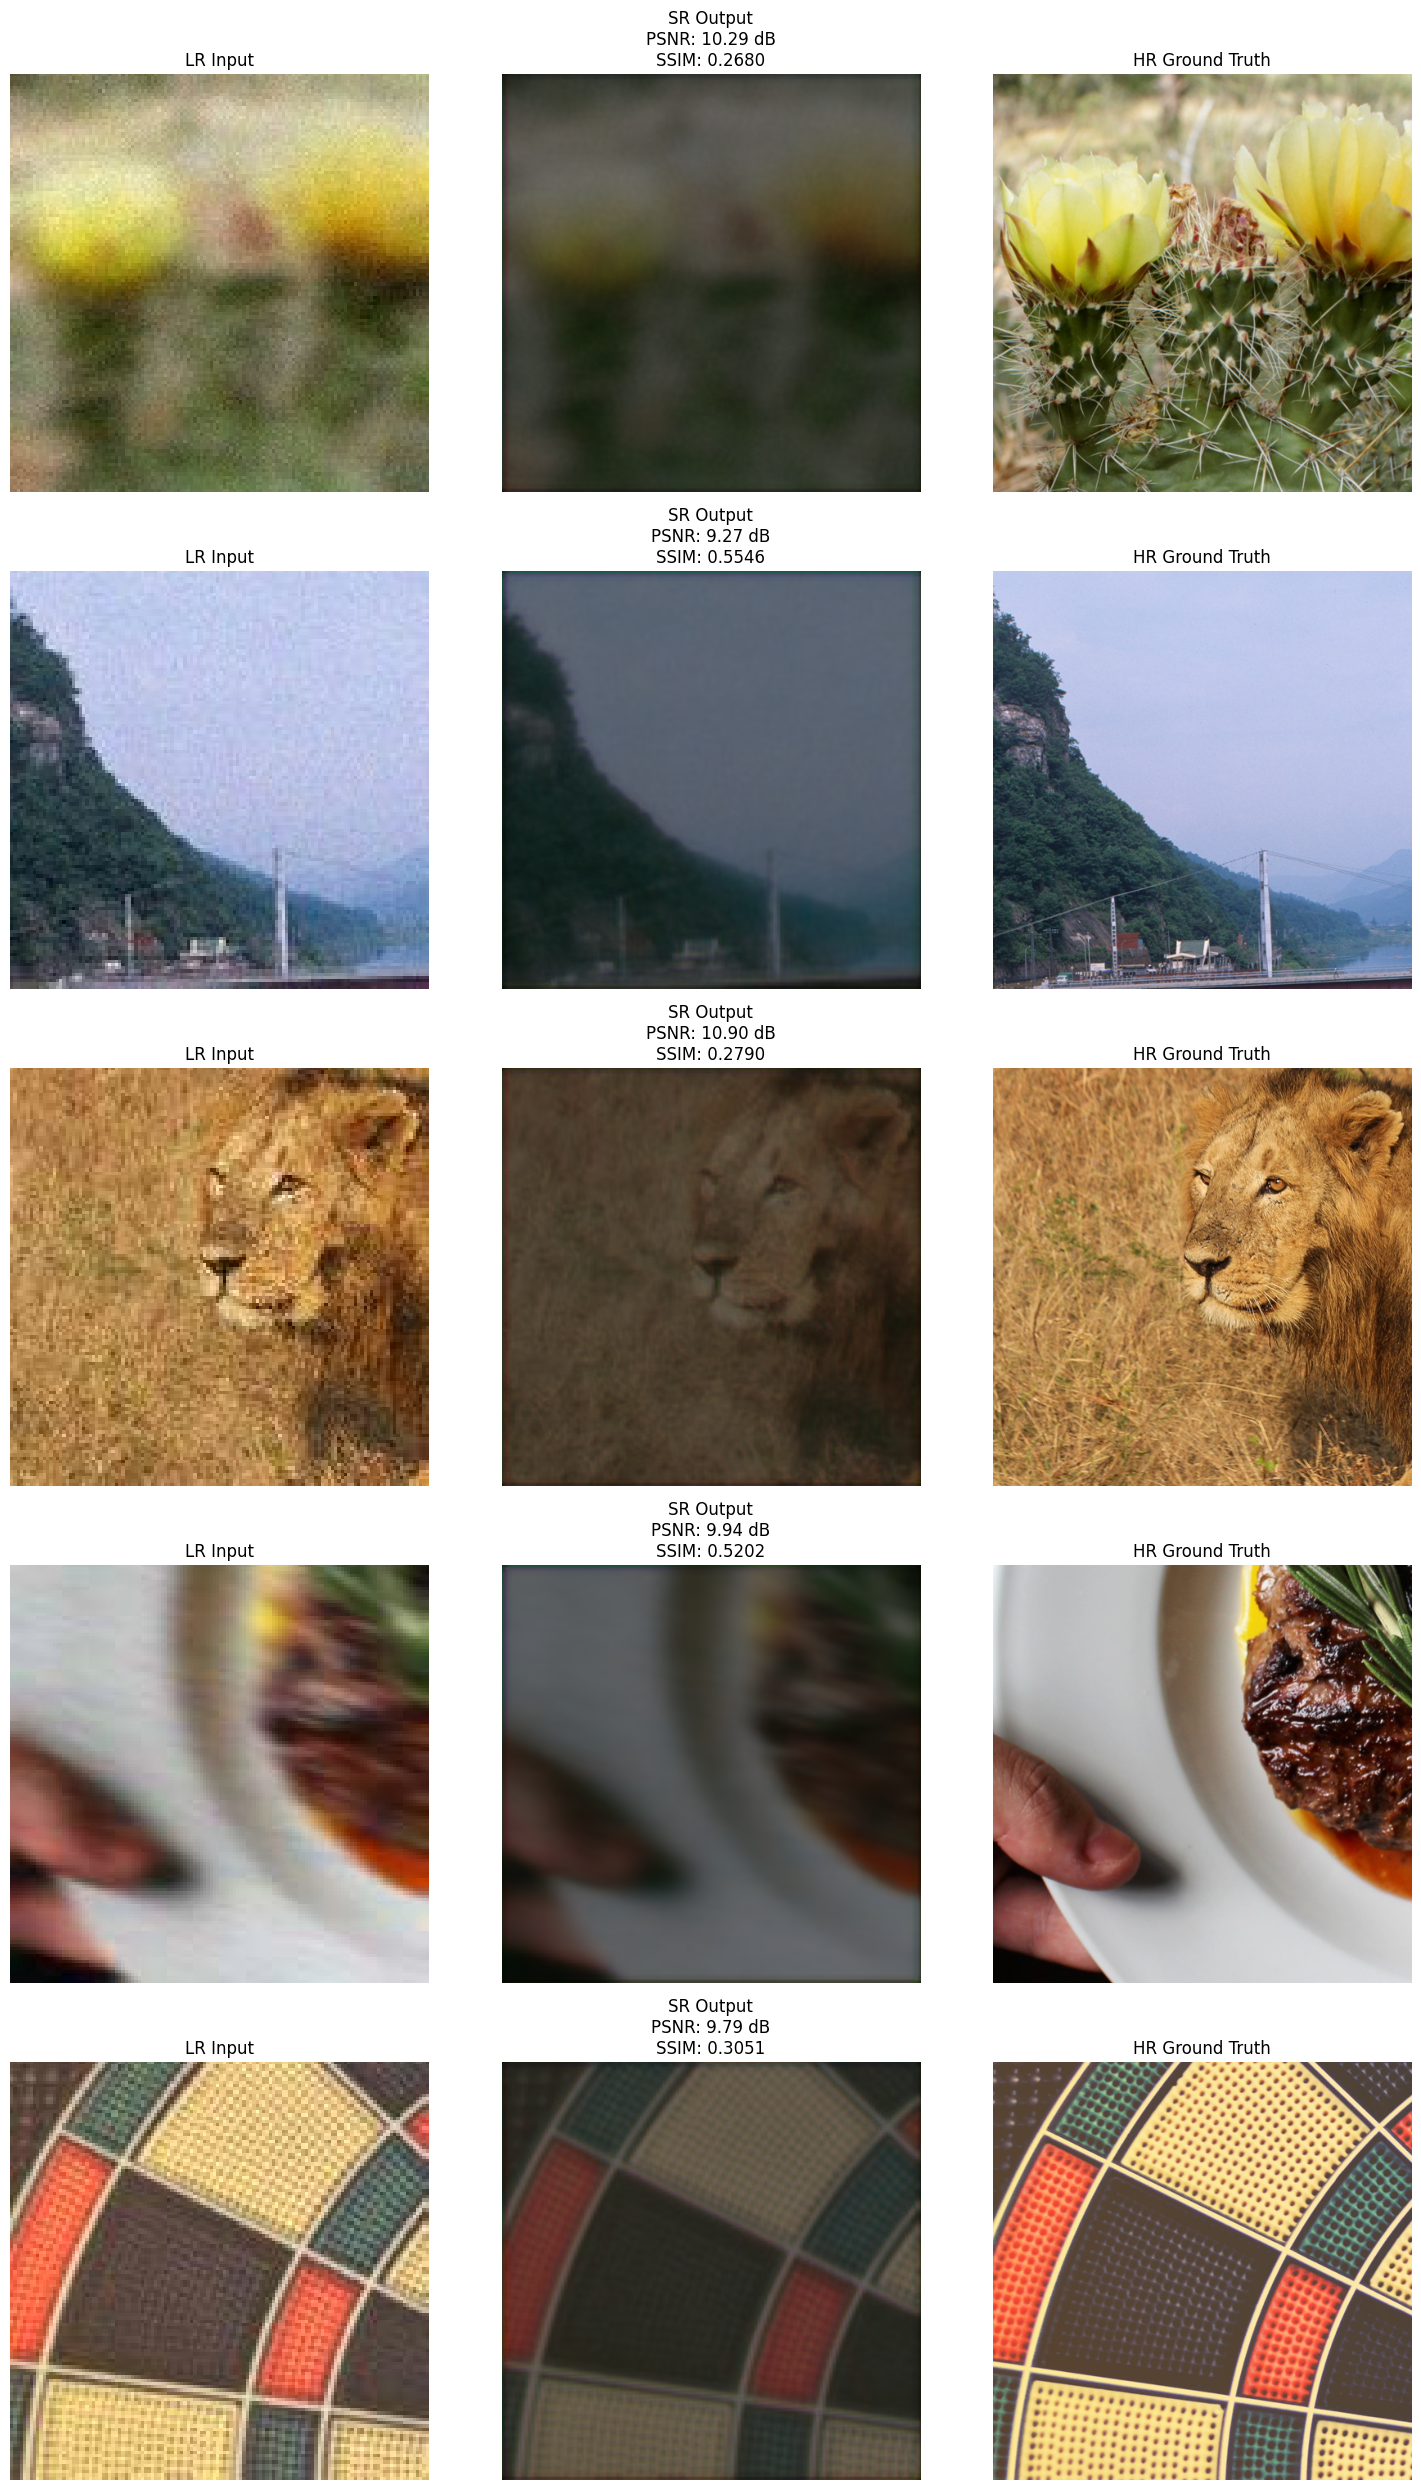

In [ ]:
# ============================================================================
# INFERENCE AND VISUALIZATION
# ============================================================================

def load_model_for_inference(checkpoint_path, device):
    """Load trained model for inference"""
    checkpoint = torch.load(checkpoint_path, map_location=device)

    model = RRDBNetLightweight(num_block=16).to(device)
    model.load_state_dict(checkpoint['ema_generator_state'])
    model.eval()

    print(f"Model loaded from {checkpoint_path}")
    print(f"Validation PSNR: {checkpoint['val_psnr']:.2f} dB")
    print(f"Validation SSIM: {checkpoint['val_ssim']:.4f}")

    return model

@torch.no_grad()
def inference_on_image(model, lr_image_path, device):
    """Run inference on a single image"""
    # Load image
    lr_img = cv2.imread(lr_image_path)
    lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)

    # Convert to tensor
    lr_tensor = torch.from_numpy(lr_img.transpose(2, 0, 1)).float() / 255.0
    lr_tensor = lr_tensor.unsqueeze(0).to(device)

    # Generate SR
    sr_tensor = model(lr_tensor)

    # Convert back to image
    sr_img = sr_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    sr_img = np.clip(sr_img * 255, 0, 255).astype(np.uint8)

    return sr_img

def visualize_results(model, val_loader, device, num_samples=5):
    """Visualize some results"""
    import matplotlib.pyplot as plt

    model.eval()

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    for i, batch in enumerate(val_loader):
        if i >= num_samples:
            break

        lr_img = batch['lr'].to(device)
        hr_img = batch['hr'].to(device)

        with torch.no_grad():
            sr_img = model(lr_img)

        # Convert to numpy
        lr_np = lr_img.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        hr_np = hr_img.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        sr_np = sr_img.squeeze(0).cpu().numpy().transpose(1, 2, 0)

        # Calculate metrics
        psnr = calculate_psnr(sr_img, hr_img).item()
        ssim = calculate_ssim(sr_img, hr_img).item()

        # Plot
        axes[i, 0].imshow(lr_np)
        axes[i, 0].set_title('LR Input')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(sr_np)
        axes[i, 1].set_title(f'SR Output\nPSNR: {psnr:.2f} dB\nSSIM: {ssim:.4f}')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(hr_np)
        axes[i, 2].set_title('HR Ground Truth')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/results/comparison.png', dpi=150)
    print("Visualization saved!")
    plt.show()

# Load best model and visualize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = load_model_for_inference(
    '/content/drive/MyDrive/AdvanceML210203M/realesrgan_experiments/checkpoints/best_model.pth',
    device
)
visualize_results(best_model, val_loader, device, num_samples=5)